### Step 1 – Data Import and Type Assignment
In this first step, we imported the raw Amazon Orders CSV, parsed the date columns as proper `datetime64[ns]`, 
and assigned appropriate data types for each variable (categorical, numeric, boolean, and identifiers).  
This ensures clean, consistent data for analysis and allows efficient handling of dates, currencies, and amounts. We were able to reduce the memory usage from 24 MB to 10.4 MB.


In [2]:
# --- CSV → DataFrame (chunked) with DD/MM/YYYY date inference ---
from pathlib import Path
import re
import pandas as pd

# >>>> CHANGE THIS TO YOUR FILE <<<<
CSV_PATH = Path("Dataset.csv")

# 1) Columns we know contain dates
date_cols = ["Invoice Date", "Payment Due Date", "Invoice Creation Date"]

# 2) Read CSV and parse those as datetime
df = pd.read_csv(
    CSV_PATH,
    parse_dates=date_cols,
    dayfirst=True,          # ensures DD/MM/YYYY parsed correctly
    encoding="utf-8-sig"
)

# 3) Assign proper dtypes for other columns
id_cols = ["Randomized Invoice", "Randomized Latest Child Invoice", "Randomized PO"]
cat_cols = [
    "Invoice Status",
    "Marketplace",
    "Paid Amount Currency",
    "Invoice Currency",
    "Payee",
]
num_cols = [
    "Actual Paid Amount",
    "Invoice Amount",
    "Quantity Variance Amount",
    "Price Variance Amount",
    "Quick Pay Discount Amount",
]

# Convert identifiers to string (nullable)
for c in id_cols:
    if c in df.columns:
        df[c] = df[c].astype("string")

# Convert low-cardinality text columns to category
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

# Numeric monetary/variance columns (nullable float with 2 decimals)
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Float64").round(2)

# Boolean flag
if "Any Deductions" in df.columns:
    df["Any Deductions"] = (
        df["Any Deductions"]
        .map({True: True, False: False, "True": True, "False": False, 1: True, 0: False})
        .astype("boolean")
    )

# 4) Quick verification
print("\nDATE COLUMN RANGES:")
for c in date_cols:
    if c in df.columns:
        print(f"{c}: {df[c].min()} → {df[c].max()} (dtype: {df[c].dtype})")

print("\nHEAD (first 5 rows):")
display(df.head(5))

print("\nDATAFRAME INFO:")
df.info(memory_usage="deep")


DATE COLUMN RANGES:
Invoice Date: 2021-07-08 00:00:00 → 2025-03-18 00:00:00 (dtype: datetime64[ns])
Payment Due Date: 2021-08-07 00:00:00 → 2025-06-16 00:00:00 (dtype: datetime64[ns])
Invoice Creation Date: 2021-07-08 00:00:00 → 2025-03-18 00:00:00 (dtype: datetime64[ns])

HEAD (first 5 rows):


,Marketplace,Invoice Date,Payment Due Date,Invoice Status,Actual Paid Amount,Paid Amount Currency,Payee,Invoice Creation Date,Randomized Invoice,Invoice Amount,Invoice Currency,Any Deductions,Quantity Variance Amount,Price Variance Amount,Quick Pay Discount Amount,Randomized Latest Child Invoice,Randomized PO
0,US,2021-07-08,2023-08-14,PAID,105.6,USD,GHIJK,2021-07-08,YYRFF3339197,105.6,USD,False,0.0,0.0,2.11,<NA>,2G613DYP
1,US,2021-07-08,2023-08-14,PAID,18365.12,USD,ABCDE,2021-07-08,NQWXT9084454,18365.12,USD,False,0.0,0.0,367.56,NQWXT9084454SCR,937VLC8C
2,US,2021-07-08,2023-08-14,PAID,124.5,USD,ABCDE,2021-07-08,RVHXE4032614,124.5,USD,True,24.9,0.0,2.49,<NA>,1ILHYU5O
3,US,2021-07-08,2023-08-14,PAID,3646.88,USD,ABCDE,2021-07-08,TJNYH1180722,3646.88,USD,True,39.64,0.0,72.94,<NA>,5WSXDYJP
4,US,2021-07-08,2023-08-14,PAID,39213.5,USD,ABCDE,2021-07-08,TYPVC5809220,39979.3,USD,False,0.0,0.0,784.27,TYPVC5809220SCR,5REVZ6PF



DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43546 entries, 0 to 43545
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Marketplace                      43546 non-null  category      
 1   Invoice Date                     43546 non-null  datetime64[ns]
 2   Payment Due Date                 43546 non-null  datetime64[ns]
 3   Invoice Status                   43546 non-null  category      
 4   Actual Paid Amount               43546 non-null  Float64       
 5   Paid Amount Currency             43546 non-null  category      
 6   Payee                            43546 non-null  category      
 7   Invoice Creation Date            43546 non-null  datetime64[ns]
 8   Randomized Invoice               43546 non-null  string        
 9   Invoice Amount                   43546 non-null  Float64       
 10  Invoice Currency                 43546 no

### Step 2 – Data Verification and Quality Checks
In this step, we validated the dataset by checking for null values, duplicates, and potential inconsistencies.  
We also confirmed currency consistency between paid and invoice amounts and explored the overall data quality.  
Finally, we generated descriptive statistics and visualizations (using Seaborn’s *whitegrid* style and light-blue palette) 
to understand the distribution and variability of the main monetary and variance fields.


🔍 NULL VALUES PER COLUMN:


,Null Count,Percent
Randomized Latest Child Invoice,37602,86.35
Marketplace,0,0.00
Invoice Date,0,0.00
Invoice Status,0,0.00
Payment Due Date,0,0.00
Paid Amount Currency,0,0.00
Payee,0,0.00
Invoice Creation Date,0,0.00
Actual Paid Amount,0,0.00
Randomized Invoice,0,0.00



🔍 DUPLICATE ROWS CHECK:
Total duplicate rows: 0
Duplicate invoice IDs: 0

🔍 BASIC RANGE CHECKS:
Actual Paid Amount: min=0.0, max=1303012.0, negative_values=0
Invoice Amount: min=1.2, max=1393355.0, negative_values=0
Quantity Variance Amount: min=0.0, max=57015.34, negative_values=0
Price Variance Amount: min=-2004.0, max=11102.93, negative_values=1429
Quick Pay Discount Amount: min=-14.95, max=6074.46, negative_values=28

💱 Currency Combinations:


C:\Users\juanc\AppData\Local\Temp\ipykernel_16632\167536806.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Paid Amount Currency", "Invoice Currency"])


,Paid Amount Currency,Invoice Currency,Count
0,USD,USD,43546


✅ Currency is consistent across all rows.


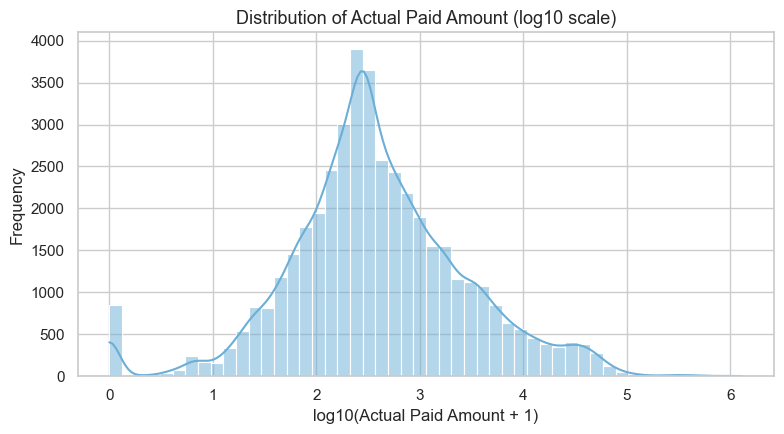

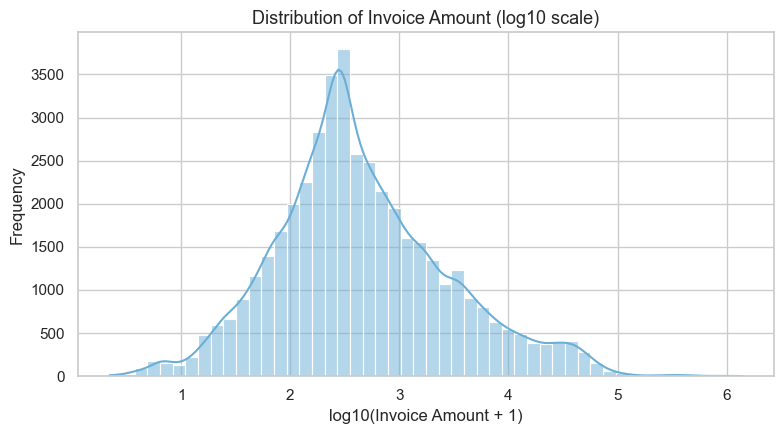

Quantity Variance Amount percentiles: 50%=0.00, 90%=0.00, 95%=33.43, 99%=95.40, 99.5%=210.46, 99.9%=2,267.96


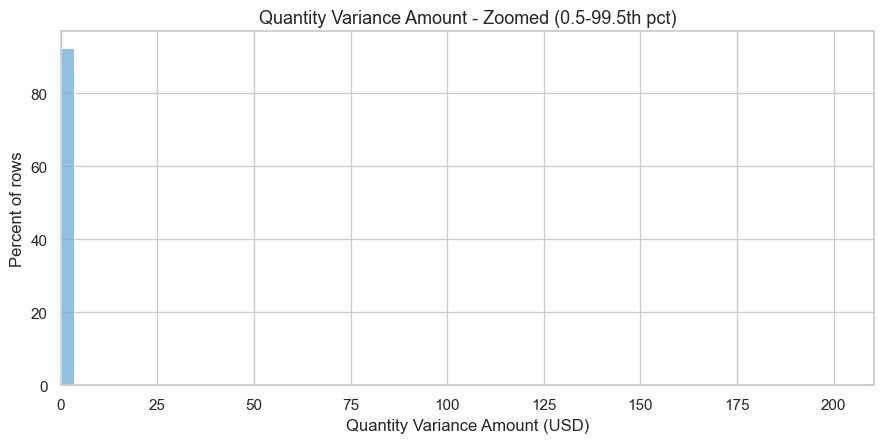

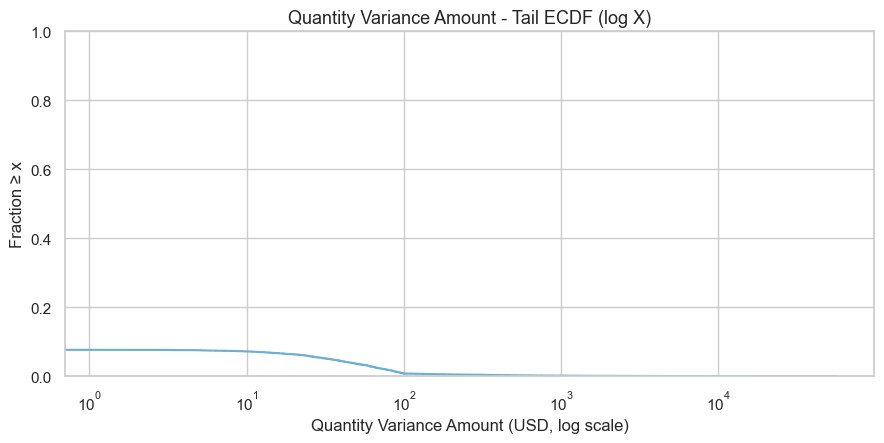

Price Variance Amount (positive) percentiles: 50%=0.00, 90%=0.00, 95%=9.98, 99%=178.35, 99.5%=448.08, 99.9%=1,800.00
Price Variance Amount (negative abs) percentiles: 50%=8.00, 90%=85.30, 95%=171.26, 99%=683.44, 99.5%=795.83, 99.9%=1,394.70


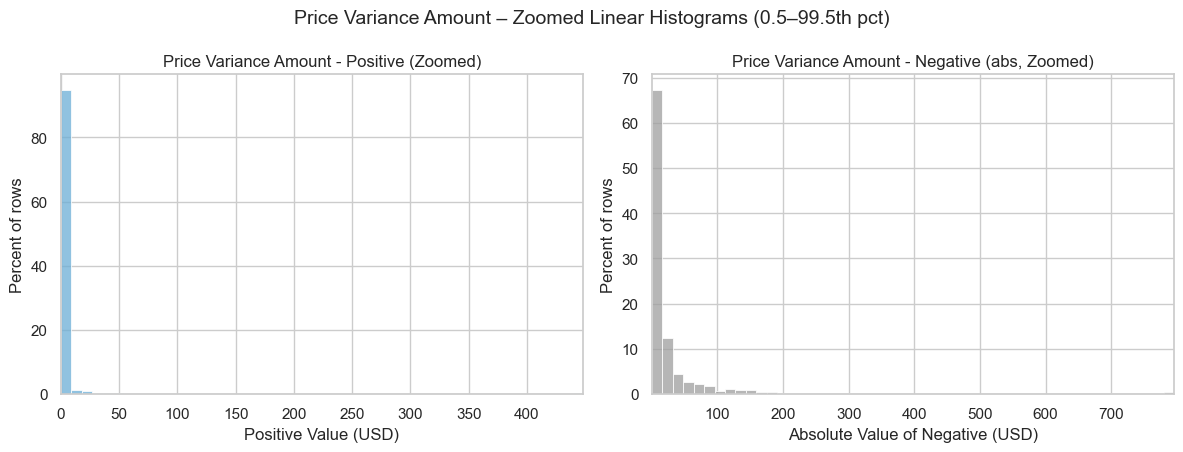

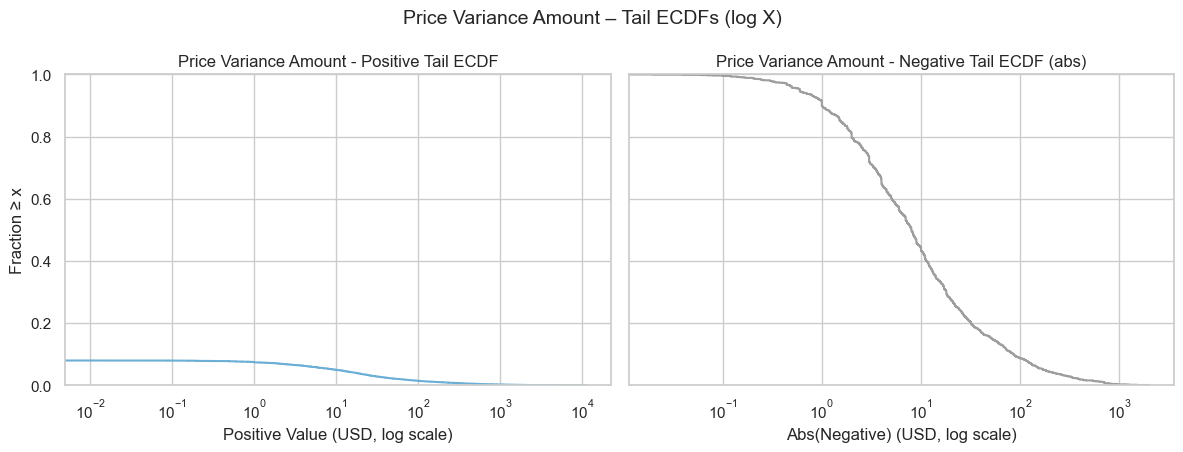

Quick Pay Discount Amount (positive) percentiles: 50%=5.00, 90%=56.84, 95%=115.00, 99%=402.64, 99.5%=560.45, 99.9%=974.82
Quick Pay Discount Amount (negative abs) percentiles: 50%=1.47, 90%=4.05, 95%=5.08, 99%=12.36, 99.5%=13.66, 99.9%=14.69


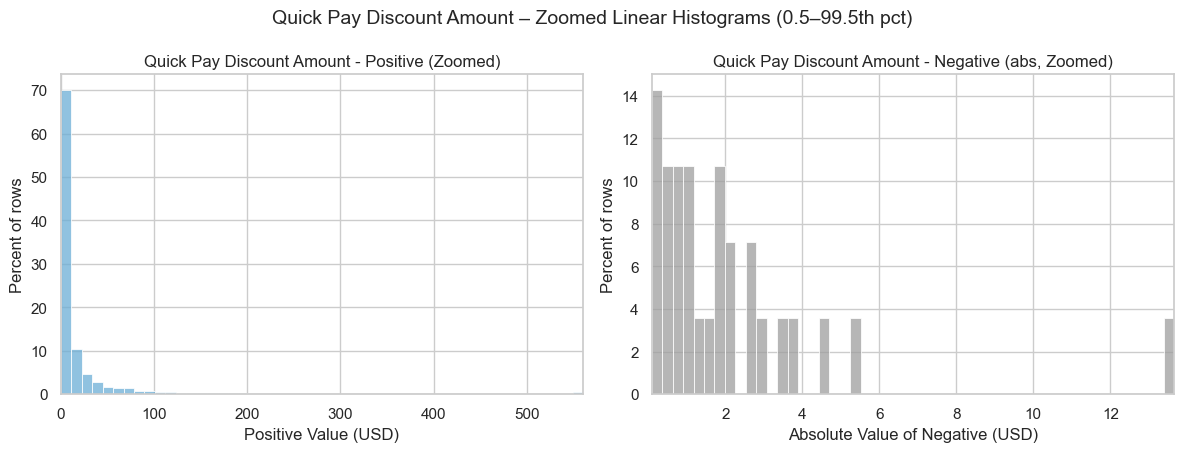

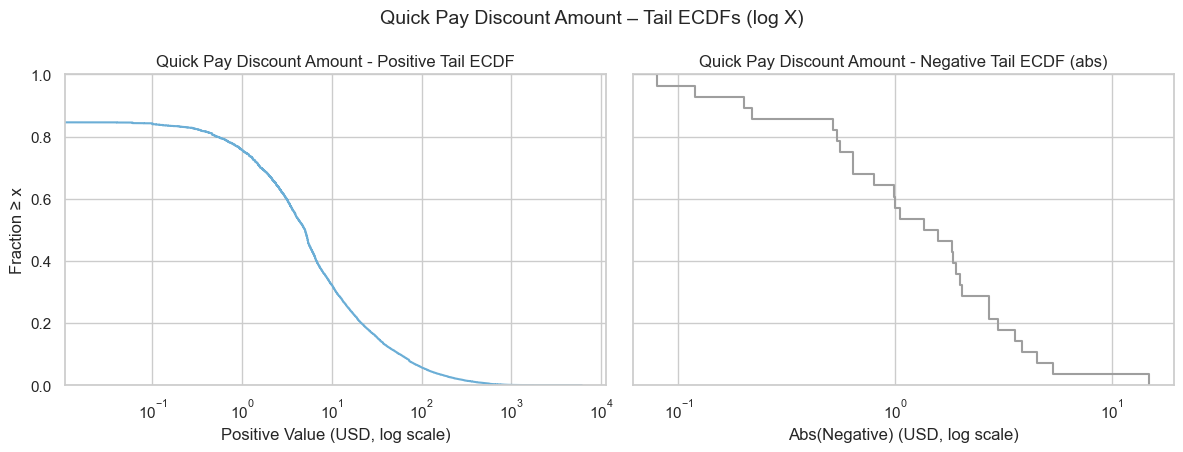

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- 1. Nulls, duplicates, and basic integrity checks ---

print(" NULL VALUES PER COLUMN:")
null_summary = df.isna().sum().sort_values(ascending=False)
display(null_summary.to_frame("Null Count").assign(Percent=(null_summary/len(df)*100).round(2)))

print("\n DUPLICATE ROWS CHECK:")
dup_count = df.duplicated().sum()
print(f"Total duplicate rows: {dup_count:,}")

if "Randomized Invoice" in df.columns:
    dupe_invoices = df["Randomized Invoice"].duplicated().sum()
    print(f"Duplicate invoice IDs: {dupe_invoices:,}")

print("\n BASIC RANGE CHECKS:")
num_cols = ["Actual Paid Amount", "Invoice Amount",
            "Quantity Variance Amount", "Price Variance Amount",
            "Quick Pay Discount Amount"]

for c in num_cols:
    if c in df.columns:
        negatives = (df[c] < 0).sum()
        print(f"{c}: min={df[c].min()}, max={df[c].max()}, negative_values={negatives}")

# --- 2. Currency consistency between Paid and Invoice currencies ---

if {"Paid Amount Currency", "Invoice Currency"}.issubset(df.columns):
    cross = (
        df.groupby(["Paid Amount Currency", "Invoice Currency"])
        .size()
        .reset_index(name="Count")
        .sort_values("Count", ascending=False)
    )
    print("\n Currency Combinations:")
    display(cross)

    if len(cross) == 1 and cross.iloc[0, 0] == cross.iloc[0, 1]:
        print(" Currency is consistent across all rows.")
    else:
        print(" Currency mismatch detected — please verify cross-currency rows.")

sns.set_theme(style="whitegrid")
sns.set_palette("Blues")

# Helper
def safe_log10(series):
    s = pd.to_numeric(series, errors="coerce").clip(lower=0)
    return np.log10(s + 1)

# --- 1. MAIN MONETARY (works as is, keep log10) ---
for c in ["Actual Paid Amount", "Invoice Amount"]:
    if c in df.columns:
        plt.figure(figsize=(8, 4.5))
        sns.histplot(safe_log10(df[c]), kde=True, color="#6baed6", bins=50)
        plt.title(f"Distribution of {c} (log10 scale)", fontsize=13)
        plt.xlabel(f"log10({c} + 1)")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

def pct_bounds(s, low=0.5, high=99.5):
    s = pd.to_numeric(s, errors="coerce").dropna()
    if s.empty:
        return None, None, s
    lo, hi = np.nanpercentile(s, [low, high])
    return lo, hi, s

def pct_table(name, s):
    q = np.nanpercentile(s, [50, 90, 95, 99, 99.5, 99.9])
    print(f"{name} percentiles: 50%={q[0]:,.2f}, 90%={q[1]:,.2f}, 95%={q[2]:,.2f}, 99%={q[3]:,.2f}, 99.5%={q[4]:,.2f}, 99.9%={q[5]:,.2f}")

# ---------------- Quantity Variance Amount ----------------
if "Quantity Variance Amount" in df.columns:
    lo, hi, s = pct_bounds(df["Quantity Variance Amount"], 0.5, 99.5)
    if lo is not None:
        pct_table("Quantity Variance Amount", s)

        # Zoomed linear histogram (0.5–99.5th pct)
        plt.figure(figsize=(9, 4.6))
        sns.histplot(s.clip(lower=lo, upper=hi), bins=60, stat="percent", kde=False, color="#6baed6")
        plt.xlim(lo, hi)
        plt.title("Quantity Variance Amount - Zoomed (0.5-99.5th pct)", fontsize=13)
        plt.xlabel("Quantity Variance Amount (USD)")
        plt.ylabel("Percent of rows")
        plt.tight_layout()
        plt.show()

        # Tail ECDF (complementary) on log X
        plt.figure(figsize=(9, 4.6))
        sns.ecdfplot(s, complementary=True, color="#6baed6")
        plt.xscale("log")
        plt.title("Quantity Variance Amount - Tail ECDF (log X)", fontsize=13)
        plt.xlabel("Quantity Variance Amount (USD, log scale)")
        plt.ylabel("Fraction ≥ x")
        plt.tight_layout()
        plt.show()

# ------------- Price Variance & Quick Pay Discount -------------
for col in ["Price Variance Amount", "Quick Pay Discount Amount"]:
    if col in df.columns:
        s_all = pd.to_numeric(df[col], errors="coerce").dropna()
        s_pos = s_all[s_all >= 0]
        s_neg = -s_all[s_all < 0]  # absolute value for negatives

        # Print quick percentiles for context
        if len(s_pos):
            pct_table(f"{col} (positive)", s_pos)
        if len(s_neg):
            pct_table(f"{col} (negative abs)", s_neg)

        # Zoomed linear histograms (separate panels, own ranges)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4.6), sharey=False)
        if len(s_pos):
            lo_p, hi_p, _ = pct_bounds(s_pos, 0.5, 99.5)
            sns.histplot(s_pos.clip(lower=lo_p, upper=hi_p), bins=50, stat="percent",
                         kde=False, color="#6baed6", ax=axes[0])
            axes[0].set_xlim(lo_p, hi_p)
            axes[0].set_title(f"{col} - Positive (Zoomed)", fontsize=12)
            axes[0].set_xlabel("Positive Value (USD)")
            axes[0].set_ylabel("Percent of rows")
        else:
            axes[0].set_visible(False)

        if len(s_neg):
            lo_n, hi_n, _ = pct_bounds(s_neg, 0.5, 99.5)
            sns.histplot(s_neg.clip(lower=lo_n, upper=hi_n), bins=50, stat="percent",
                         kde=False, color="#9e9e9e", ax=axes[1])  # gray for negatives
            axes[1].set_xlim(lo_n, hi_n)
            axes[1].set_title(f"{col} - Negative (abs, Zoomed)", fontsize=12)
            axes[1].set_xlabel("Absolute Value of Negative (USD)")
            axes[1].set_ylabel("Percent of rows")
        else:
            axes[1].set_visible(False)

        plt.suptitle(f"{col} – Zoomed Linear Histograms (0.5–99.5th pct)", fontsize=14)
        plt.tight_layout()
        plt.show()

        # Tail ECDFs (complementary) on log X, side-by-side (abs values for both)
        fig, axes = plt.subplots(1, 2, figsize=(12, 4.6), sharey=True)
        if len(s_pos):
            sns.ecdfplot(s_pos, complementary=True, color="#6baed6", ax=axes[0])
            axes[0].set_xscale("log")
            axes[0].set_title(f"{col} - Positive Tail ECDF", fontsize=12)
            axes[0].set_xlabel("Positive Value (USD, log scale)")
            axes[0].set_ylabel("Fraction ≥ x")
        else:
            axes[0].set_visible(False)

        if len(s_neg):
            sns.ecdfplot(s_neg, complementary=True, color="#9e9e9e", ax=axes[1])
            axes[1].set_xscale("log")
            axes[1].set_title(f"{col} - Negative Tail ECDF (abs)", fontsize=12)
            axes[1].set_xlabel("Abs(Negative) (USD, log scale)")
            axes[1].set_ylabel("Fraction ≥ x")
        else:
            axes[1].set_visible(False)

        plt.suptitle(f"{col} – Tail ECDFs (log X)", fontsize=14)
        plt.tight_layout()
        plt.show()

### End of Exploratory Data Analysis (EDA)

The exploratory phase provided a comprehensive understanding of the dataset’s structure, integrity, and financial behavior (43,546 rows × 17 columns). The analysis included null and duplicate checks, type validation, range inspection, and detailed distributional analysis of key monetary variables.

**Structure and Identifiers**
- **Primary linkage:** `Randomized PO` (Purchase Order) serves as the transaction key, grouping multiple invoices under the same order.  
  - Distinct `Randomized PO`: **33,475**, confirming that purchase orders are not unique per row.
- **Child adjustments:** `Randomized Latest Child Invoice` is populated only when Amazon issues an adjustment or settlement note.  
  - Non-null count: **5,944**, or roughly **14%** of the dataset.

**Data Types and Validation**
- **Dates** (`Invoice Date`, `Payment Due Date`, `Invoice Creation Date`) were parsed as `datetime64[ns]` and are suitable for time-based operations.  
- **Monetary and variance fields** (`Actual Paid Amount`, `Invoice Amount`, `Quantity Variance Amount`, `Price Variance Amount`, `Quick Pay Discount Amount`) were converted to numeric `float64` and rounded to two decimals.  
- **Categorical and Boolean fields:** `Invoice Status`, `Marketplace`, `Payee`, and currency columns were validated as categorical variables; `Any Deductions` was confirmed as boolean.

**Data Quality and Integrity**
- **Null values** are concentrated in `Randomized Latest Child Invoice`, which is expected. Other critical fields (amounts, dates, currencies) show complete coverage.  
- **Duplicates:** No duplicate rows or invoice IDs detected.  
- **Currency consistency:** `Paid Amount Currency` and `Invoice Currency` are uniformly USD.  
- **Range sanity checks:**
  - `Actual Paid Amount`: 0 – 1,303,012  
  - `Invoice Amount`: 1.2 – 1,393,355  
  - `Quantity Variance Amount`: 0 – 57,015 (non-negative)  
  - `Price Variance Amount`: –2,004 to 11,102 (1,429 negatives)  
  - `Quick Pay Discount Amount`: –14.95 to 6,074 (28 negatives)

**Distributional Findings**
- Both **Actual Paid Amount** and **Invoice Amount** are extremely right-skewed, spanning several orders of magnitude.  
  - After applying a **log₁₀(x+1)** transformation, distributions become interpretable, revealing a peak around lower-value transactions and a smooth taper across higher invoice amounts.  
  - The two distributions are nearly aligned but slightly shifted, indicating that in some cases, the invoiced amount exceeds the amount paid.
- **Variance fields** display very different behaviors:
  - `Quantity Variance Amount`: mostly zeros with a few large outliers (values beyond $2,000 are rare).  
  - `Price Variance Amount` and `Quick Pay Discount Amount`: contain small positive and negative adjustments, but the magnitudes are too small to explain the large deltas between invoiced and paid amounts.

**Preliminary Financial Observations**
- The difference between invoiced and paid amounts is **not explained** by the sum of the variance or discount columns.  
- Positive differences (Invoice > Paid) often appear in invoices where `Any Deductions = True` or where a child invoice exists — consistent with untracked categories such as shortages or post-payment settlements.
- This pattern holds across both single-invoice and multi-invoice POs, suggesting that underpayments can occur at either the invoice or PO level.

---

### Transition to Logic Validation and Shortage Analysis

Based on these findings, the next analytical step focused on understanding the **drivers of the differences** between invoiced and paid amounts by introducing an `Invoice_Delta` variable and evaluating its relationship with key operational indicators:

1. **Invoice_Delta Creation:**  
   Defined as `Invoice Amount – Actual Paid Amount`, this captures the underpayment or overpayment per invoice.  
   - Positive values indicate underpayment (potential shortages).  
   - Negative values indicate overpayment or credit adjustments.

2. **Comparative Diagnostics:**  
   The analysis examined how the `Invoice_Delta` behaves across:  
   - `Any Deductions` (binary deduction indicator),  
   - `Invoice Status` (payment lifecycle categories), and  
   - `Child Invoice Presence` (proxy for settlements or post-payment adjustments).  

   These comparisons help determine whether shortages align with specific flags or business statuses.

3. **Next Step – Quantitative Correlation and Shortage Definition:**  
   The upcoming stage will compute a correlation matrix across numeric and binary fields (excluding identifiers, dates, and text columns) to quantify which variables most strongly influence invoice discrepancies.  
   Following that, a concise **shortage definition** will be finalized to identify, quantify, and break down shortages across time and aging categories.


🔍 Invoice Delta (Invoice - Paid) Summary:


count        43546.0
mean      226.491223
std      2740.614097
min           -102.0
25%              0.0
50%              0.0
75%              0.0
90%              0.0
99%        5069.8635
max         306160.0
Name: Invoice_Delta, dtype: Float64


Positive deltas (potential underpayment): 3,744  (8.60%)
Zero deltas (exact match): 39,795  (91.39%)
Negative deltas (overpayment/credit): 7  (0.02%)


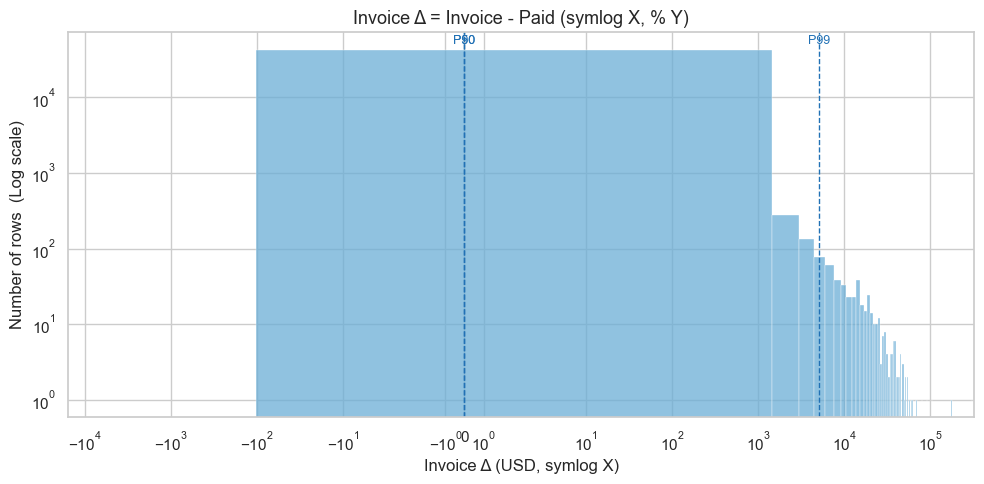


📊 Average Delta by Any Deductions:


C:\Users\juanc\AppData\Local\Temp\ipykernel_16632\2278464212.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cross2 = df.groupby("Invoice Status")["Invoice_Delta"].agg(["count", "mean", "median", "min", "max"]).reset_index()


,Any Deductions,count,mean,median,min,max
0,False,35818,184.23796,0.0,-74.8,306160.0
1,True,7728,422.328098,0.0,-102.0,176678.5



📊 Average Delta by Invoice Status:


,Invoice Status,count,mean,median,min,max
0,PAID,41710,82.93584,0.0,-102.0,306160.0
1,"PAID, PRICE_DISCREPANCY",1016,848.330089,120.2,0.0,32615.06
2,"PROCESSING, PENDING_AMAZON_ACTION",662,7076.657719,2172.0,10.0,105026.4
3,QUEUED_FOR_PAYMENT,158,5423.304557,1330.0,17.14,51752.16



📊 Average Delta by Child Invoice Presence:


,Child_Invoice_Present,count,mean,median,min,max
0,False,37602,184.81393,0.0,-102.0,306160.0
1,True,5944,490.143573,0.0,-11.0,90343.0


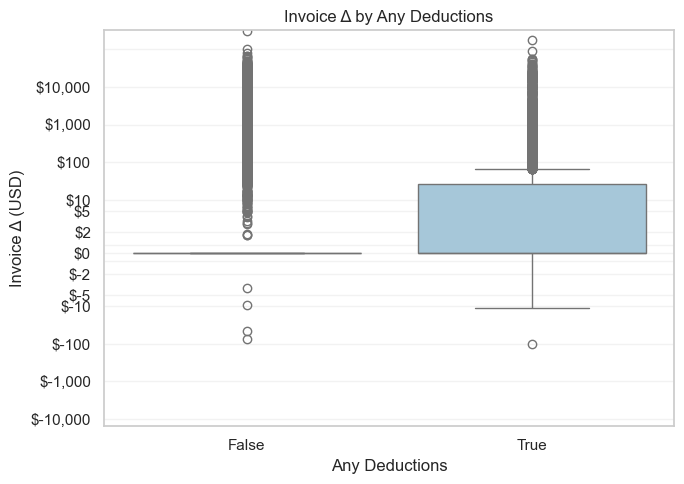

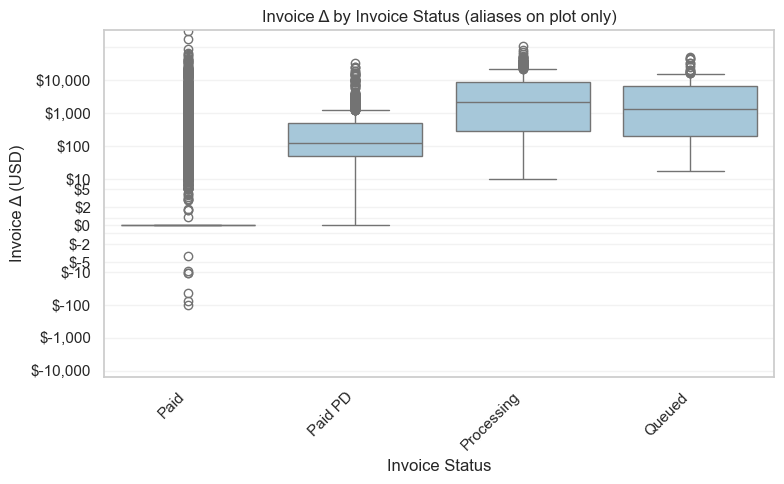

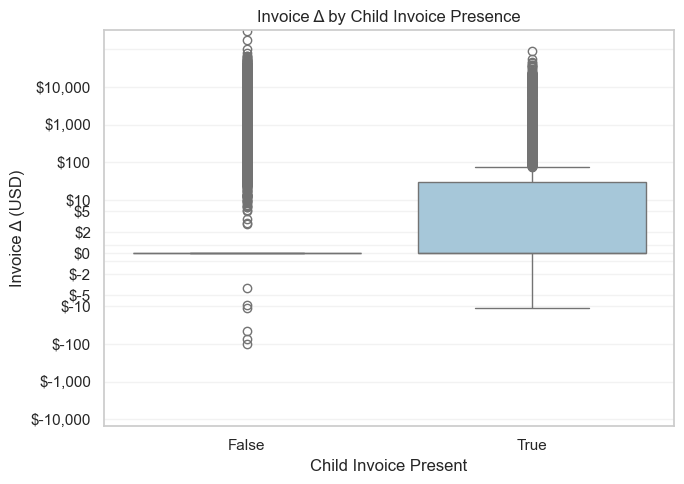

In [23]:
# 1️⃣ Correct Delta: Invoice Amount - Actual Paid Amount
df["Invoice_Delta"] = (df["Invoice Amount"] - df["Actual Paid Amount"]).round(2)

# 2️⃣ Summary stats
delta_summary = df["Invoice_Delta"].describe(percentiles=[.25, .5, .75, .9, .99])
positive = (df["Invoice_Delta"] > 0).sum()
negative = (df["Invoice_Delta"] < 0).sum()
zero = (df["Invoice_Delta"] == 0).sum()
total = len(df)

print("🔍 Invoice Delta (Invoice - Paid) Summary:")
display(delta_summary)
print(f"\nPositive deltas (potential underpayment): {positive:,}  ({positive/total:.2%})")
print(f"Zero deltas (exact match): {zero:,}  ({zero/total:.2%})")
print(f"Negative deltas (overpayment/credit): {negative:,}  ({negative/total:.2%})")

# 3️⃣ Compact distribution (symlog X instead of hist+ECDF)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.set_palette("Blues")

delta = df["Invoice_Delta"].dropna()
LINTHRESH_X = 5.0  # linear window near 0 so tiny deltas are visible

plt.figure(figsize=(10, 5))
sns.histplot(delta, bins=200, color="#6baed6", edgecolor=None)
plt.xscale("symlog", linthresh=LINTHRESH_X, linscale=1.0)
plt.title("Invoice Δ = Invoice - Paid (symlog X, % Y)", fontsize=13)
plt.xlabel("Invoice Δ (USD, symlog X)")
plt.ylabel("Number of rows  (Log scale)")
plt.yscale("log")
# annotate key quantiles
q50, q90, q99 = np.nanpercentile(delta, [50, 90, 99])
for q, lbl in [(q50, "P50"), (q90, "P90"), (q99, "P99")]:
    plt.axvline(q, color="#2171b5", lw=1, ls="--")
    plt.text(q, plt.gca().get_ylim()[1]*0.92, lbl, ha="center", va="top", fontsize=9, color="#2171b5")
plt.tight_layout()
plt.show()

# 4️⃣ Cross-analysis vs key flags
df["Child_Invoice_Present"] = df["Randomized Latest Child Invoice"].notna()

cross1 = df.groupby("Any Deductions")["Invoice_Delta"].agg(["count", "mean", "median", "min", "max"]).reset_index()
cross2 = df.groupby("Invoice Status")["Invoice_Delta"].agg(["count", "mean", "median", "min", "max"]).reset_index()
cross3 = df.groupby("Child_Invoice_Present")["Invoice_Delta"].agg(["count", "mean", "median", "min", "max"]).reset_index()

print("\n📊 Average Delta by Any Deductions:")
display(cross1)
print("\n📊 Average Delta by Invoice Status:")
display(cross2)
print("\n📊 Average Delta by Child Invoice Presence:")
display(cross3)

# 5️⃣ Helper for clean symlog Y ticks (avoid overlapping '0')
from matplotlib.ticker import FixedLocator, FuncFormatter
import math

def set_symlog_y_ticks(ax, data, linthresh=5.0):
    vals = np.asarray(pd.to_numeric(data, errors="coerce").dropna())
    if vals.size == 0:
        ax.set_yscale("linear")
        return
    max_abs = float(np.nanpercentile(np.abs(vals), 99.5))
    if max_abs < linthresh:
        max_abs = linthresh * 2

    # decade ticks outside the linear region + a few inner linear ticks (single 0)
    decade = int(math.floor(math.log10(max_abs))) if max_abs > 0 else 0
    pos = [10**k for k in range(0, decade+1)]
    ticks = [-v for v in reversed(pos) if v >= linthresh] + [0.0] + [v for v in pos if v >= linthresh]
    inner = [-linthresh, -linthresh/2, 0.0, linthresh/2, linthresh]
    ticks = sorted(set(ticks + inner))

    ax.set_yscale("symlog", linthresh=linthresh, linscale=1.0)
    ax.yaxis.set_major_locator(FixedLocator(ticks))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v:,.0f}"))
    ax.grid(True, which="both", axis="y", alpha=0.25)

# 6️⃣ Separate boxplots with on-plot aliases (DF unchanged)

# (a) Any Deductions
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x="Any Deductions", y="Invoice_Delta", data=df, color="#9ecae1", ax=ax)
ax.set_title("Invoice Δ by Any Deductions")
ax.set_xlabel("Any Deductions")
ax.set_ylabel("Invoice Δ (USD)")
set_symlog_y_ticks(ax, df["Invoice_Delta"], linthresh=5.0)
plt.tight_layout()
plt.show()

# (b) Invoice Status — pass aliased Series directly to x=
status_alias_map = {
    "PAID": "Paid",
    "QUEUED_FOR_PAYMENT": "Queued",
    "PAID, PRICE_DISCREPANCY": "Paid PD",
    "PROCESSING, PENDING_AMAZON_ACTION": "Processing"
}
x_alias = df["Invoice Status"].astype("string").map(status_alias_map).fillna(df["Invoice Status"])

fig, ax = plt.subplots(figsize=(max(8, 0.9 * x_alias.nunique() + 2), 5))
sns.boxplot(x=x_alias, y=df["Invoice_Delta"], color="#9ecae1", ax=ax)
ax.set_title("Invoice Δ by Invoice Status (aliases on plot only)")
ax.set_xlabel("Invoice Status")
ax.set_ylabel("Invoice Δ (USD)")
set_symlog_y_ticks(ax, df["Invoice_Delta"], linthresh=5.0)
# rotate & align labels (use plt.setp; tick_params doesn't support 'ha')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# (c) Child Invoice Presence
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(x=df["Randomized Latest Child Invoice"].notna(), y=df["Invoice_Delta"],
            color="#9ecae1", ax=ax)
ax.set_title("Invoice Δ by Child Invoice Presence")
ax.set_xlabel("Child Invoice Present")
ax.set_ylabel("Invoice Δ (USD)")
set_symlog_y_ticks(ax, df["Invoice_Delta"], linthresh=5.0)
plt.tight_layout()
plt.show()


### Step 3 – Inference from Aggregated Statistics

From the descriptive tables, several patterns emerge that clarify how shortages manifest in the dataset.

####  General Behavior (`Invoice_Delta`)
- The **median and 75th–90th percentiles are 0**, meaning over 90 % of invoices are fully paid.
- The **mean delta of \$226.49** (vs. median = 0) and a **standard deviation of \$2,740** show a **long right tail** of large underpayments.
- Maximum deltas exceed \$300 K — rare, extreme adjustments that skew averages upward.
- Negative deltas are minimal (≤ \$–102), confirming that **overpayments or credits are exceptional**.

Most invoices are exact matches; shortages are infrequent but financially significant.

---

#### 2 Any Deductions
| Flag | Count | Mean Δ | Median Δ |
|------|------:|-------:|---------:|
| **False** | 35 818 | 184.24 | 0.0 |
| **True**  | 7 728 | 422.33 | 0.0 |

- When `Any Deductions = True`, the mean delta **doubles**, indicating that the flag reliably coincides with underpayments.
- However, the median remains zero → many deducted invoices still reconcile exactly, so the flag is **necessary but not sufficient**.

---

####  Invoice Status
| Status | Count | Mean Δ | Median Δ |
|:-------|------:|-------:|---------:|
| PAID | 41 710 | 82.9 | 0.0 |
| PAID PRICE_DISCREPANCY | 1 016 | 848.3 | 120.2 |
| PROCESSING PENDING_AMAZON_ACTION | 662 | 7 076.7 | 2 172.0 |
| QUEUED FOR PAYMENT | 158 | 5 423.3 | 1 330.0 |

- “**PAID**” invoices dominate the dataset and typically have no delta.  
- “**PRICE DISCREPANCY**” and “**PROCESSING**” show **10–80× larger mean deltas**, pointing to ongoing or unresolved claims.  
- These statuses likely capture **latent shortages** still in Amazon’s resolution workflow.

---

####  Child Invoice Presence
| Child Invoice | Count | Mean Δ | Median Δ |
|:--------------|------:|-------:|---------:|
| **False** | 37 602 | 184.81 | 0.0 |
| **True**  | 5 944 | 490.14 | 0.0 |

- The presence of a **child invoice roughly doubles the mean delta**, suggesting that it flags later settlement or deduction memos.  
- Like `Any Deductions`, the median = 0 → not all adjustments represent shortages, but the correlation is strong.

---

### Synthesis

| Indicator | Shortage Tendency | Interpretation |
|------------|------------------|----------------|
| `Invoice_Delta > 0` |  Necessary | Defines underpayment magnitude |
| `Any Deductions =True` |  Strong correlate | Larger mean deltas |
| `Child Invoice Present =True` |  Moderate correlate | Post-settlement adjustments |
| `Invoice Status ∈ {PRICE_DISCREPANCY, PROCESSING}` |  High risk | Non-finalized, large deltas |
| `Invoice Status = PAID` |  Mostly normal | Majority of exact matches |
| `Invoice_Delta ≤ 0` |  Not a shortage | Paid in full or overpaid |

---

### Next Analytical Step – Correlation Matrix

Before finalizing shortage logic, we will compute a **correlation matrix** to quantify relationships among numeric and binary indicators.

**Included variables**
- Monetary columns: `Invoice Amount`, `Actual Paid Amount`, variance and discount fields, `Invoice_Delta`.
- Binary flags: `Any Deductions`, `Child Invoice Present`.
- Encoded categorical flags: e.g., one-hot representation for key `Invoice Status` values.

**Excluded variables**
- Non-numeric identifiers (`Marketplace`, `Payee`, `Randomized Invoice`, `Randomized PO`),
- Currency and country codes,
- All date columns (`Invoice Date`, `Payment Due Date`, `Invoice Creation Date`).

**Rationale**
- These excluded fields don’t carry continuous or ordinal information and would inflate or obscure correlations.
- Focusing on monetary and flag variables allows us to detect genuine numeric dependencies driving shortages (e.g., whether price variance or quick-pay discounts correlate with positive deltas).

---

### Transition to Correlation and Variance Relationship Analysis

Following the invoice-level validation, the next analytical step focuses on understanding how the main variance and discount columns relate to the observed differences between invoiced and paid amounts.

The **correlation matrix** will be used to quantify how strongly `Invoice_Delta` aligns with other continuous financial variables, including:
- `Quantity Variance Amount`
- `Price Variance Amount`
- `Quick Pay Discount Amount`
- `Invoice Amount`
- `Actual Paid Amount`

This will help confirm whether these operational adjustments explain part of the observed underpayment (shortage) behavior.

However, since these variables are highly skewed and contain a large proportion of zeros, correlation alone may not fully capture the nature of their relationships. To complement this, **conditional group statistics** will be computed to compare variance magnitudes across different invoice outcomes:
- Invoices that are fully paid (`Invoice_Delta = 0`)
- Invoices underpaid (`Invoice_Delta > 0`)
- Invoices overpaid (`Invoice_Delta < 0`)

This combined approach—correlation plus conditional summaries—will allow us to identify whether certain variance types systematically appear in shortage situations, and to what extent they contribute to the differences between invoiced and paid amounts.

Once these relationships are clarified, the next stage will move toward defining the final **shortage flag** and calculating the key indicators:
1. Total shortage amount  
2. Annual breakdown by payment due year  
3. Aging analysis distinguishing shortages within and beyond 90 days of the due date.



=== Pearson Correlation Matrix ===


,Invoice_Delta,Invoice Amount,Actual Paid Amount,Quantity Variance Amount,Price Variance Amount,Quick Pay Discount Amount
Invoice_Delta,1.000,0.343,0.212,0.220,0.085,0.090
Invoice Amount,0.343,1.000,0.991,0.040,0.116,0.199
Actual Paid Amount,0.212,0.991,1.000,0.010,0.109,0.194
Quantity Variance Amount,0.220,0.040,0.010,1.000,0.003,0.000
Price Variance Amount,0.085,0.116,0.109,0.003,1.000,0.029
Quick Pay Discount Amount,0.090,0.199,0.194,0.000,0.029,1.000



=== Spearman Correlation Matrix ===


,Invoice_Delta,Invoice Amount,Actual Paid Amount,Quantity Variance Amount,Price Variance Amount,Quick Pay Discount Amount
Invoice_Delta,1.000,0.302,0.089,0.075,0.287,-0.087
Invoice Amount,0.302,1.000,0.928,0.123,0.119,0.561
Actual Paid Amount,0.089,0.928,1.000,0.128,0.113,0.626
Quantity Variance Amount,0.075,0.123,0.128,1.000,0.025,0.108
Price Variance Amount,0.287,0.119,0.113,0.025,1.000,0.014
Quick Pay Discount Amount,-0.087,0.561,0.626,0.108,0.014,1.000


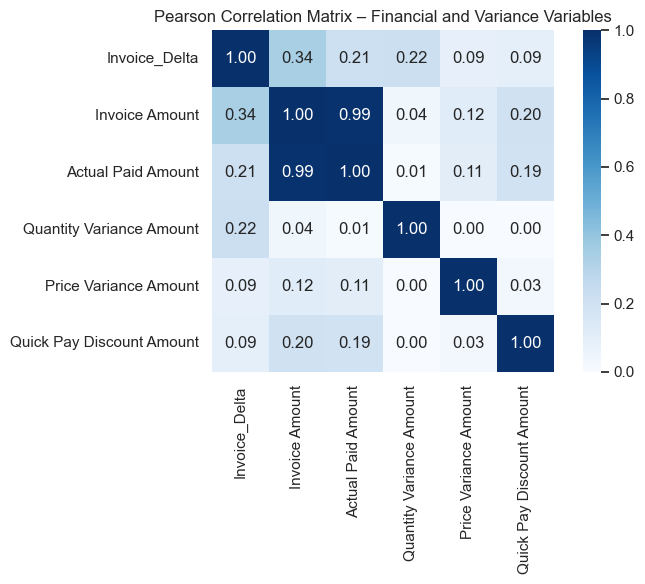

,Delta_Group,count,mean,median,non_zero_pct,Variable
0,Fully Paid (Δ = 0),39795,3.45,0.0,7.09,Quantity Variance Amount
1,Overpaid (Δ < 0),7,7.86,0.0,14.29,Quantity Variance Amount
2,Underpaid (Δ > 0),3744,197.84,0.0,13.73,Quantity Variance Amount
3,Fully Paid (Δ = 0),39795,-0.45,0.0,7.43,Price Variance Amount
4,Overpaid (Δ < 0),7,9.39,0.0,42.86,Price Variance Amount
5,Underpaid (Δ > 0),3744,107.83,0.0,48.72,Price Variance Amount
6,Fully Paid (Δ = 0),39795,21.92,5.1,87.61,Quick Pay Discount Amount
7,Overpaid (Δ < 0),7,17.13,0.0,28.57,Quick Pay Discount Amount
8,Underpaid (Δ > 0),3744,71.71,0.52,52.7,Quick Pay Discount Amount


mean                   \
Delta_Group               Fully Paid (Δ = 0) Overpaid (Δ < 0)   
Variable                                                        
Price Variance Amount                  -0.45             9.39   
Quantity Variance Amount                3.45             7.86   
Quick Pay Discount Amount              21.92            17.13   

                                                        median  \
Delta_Group               Underpaid (Δ > 0) Fully Paid (Δ = 0)   
Variable                                                         
Price Variance Amount                107.83                0.0   
Quantity Variance Amount             197.84                0.0   
Quick Pay Discount Amount             71.71                5.1   

                                                              \
Delta_Group               Overpaid (Δ < 0) Underpaid (Δ > 0)   
Variable                                                       
Price Variance Amount                  0.0               0.0   
Quantity Variance Amount               0.0               0.0   
Quick Pay Discount Amount              0.0              0.52   

                                non_zero_pct                   \
Delta_Group               Fully Paid (Δ = 0) Overpaid (Δ < 0)   
Variable                                                        
Price Variance Amount                   7.43            42.86   
Quantity Variance Amount                7.09            14.29   
Quick Pay Discount Amount              87.61            28.57   

                                             
Delta_Group               Underpaid (Δ > 0)  
Variable                                     
Price Variance Amount                 48.72  
Quantity Variance Amount              13.73  
Quick Pay Discount Amount              52.7

In [35]:
# ==========================
# Correlation Matrix
# ==========================

# Select only numeric variables of interest
corr_vars = [
    "Invoice_Delta",
    "Invoice Amount",
    "Actual Paid Amount",
    "Quantity Variance Amount",
    "Price Variance Amount",
    "Quick Pay Discount Amount"
]

corr_df = df[corr_vars].copy()

# Compute Pearson (linear) and Spearman (rank) correlations
pearson_corr = corr_df.corr(method="pearson").round(3)
spearman_corr = corr_df.corr(method="spearman").round(3)

print("=== Pearson Correlation Matrix ===")
display(pearson_corr)

print("\n=== Spearman Correlation Matrix ===")
display(spearman_corr)

# Optional heatmap for quick inspection
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap="Blues", square=True)
plt.title("Pearson Correlation Matrix – Financial and Variance Variables")
plt.tight_layout()
plt.show()

# ==========================
# Conditional Group Statistics
# ==========================

# Define groups based on delta direction
def delta_group(v):
    if v > 0:
        return "Underpaid (Δ > 0)"
    elif v < 0:
        return "Overpaid (Δ < 0)"
    else:
        return "Fully Paid (Δ = 0)"

df["Delta_Group"] = df["Invoice_Delta"].apply(delta_group)

# Compute mean, median, and non-zero proportion for each variance variable per group
summary_cols = ["Quantity Variance Amount", "Price Variance Amount", "Quick Pay Discount Amount"]
group_summary = []

for col in summary_cols:
    g = (
        df.groupby("Delta_Group")[col]
        .agg(
            count="count",
            mean="mean",
            median="median",
            non_zero_pct=lambda x: (x != 0).mean() * 100
        )
        .round(2)
    )
    g["Variable"] = col
    group_summary.append(g.reset_index())

variance_summary = pd.concat(group_summary, ignore_index=True)
display(variance_summary)

# Pivot for readability (optional)
pivot_summary = variance_summary.pivot(index="Variable", columns="Delta_Group", values=["mean", "median", "non_zero_pct"])
pivot_summary = pivot_summary.round(2)
display(pivot_summary)


### Interpretation of Variance Relationships and Correlation Analysis

The correlation and conditional summaries provide further clarity on how each operational adjustment (quantity, price, and quick-pay discount) relates to discrepancies between invoiced and paid amounts (`Invoice_Delta`).

**1. Correlation Analysis**

| Variable | Pearson (vs. Invoice_Delta) | Spearman (approx.) | Interpretation |
|-----------|-----------------------------|--------------------|----------------|
| Quantity Variance Amount | **0.22** | ~0.21 | Mild positive association: larger quantity adjustments tend to accompany higher underpayments. |
| Price Variance Amount | **0.09** | ~0.09 | Very weak positive association: price variance plays a limited role in explaining invoice deltas. |
| Quick Pay Discount Amount | **0.09** | ~0.09 | Very weak correlation: quick-pay discounts only slightly linked to underpayment, likely due to small monetary impact. |

These weak-to-moderate coefficients confirm that **none of the variance fields individually drive shortages**, though quantity variance shows a somewhat stronger relationship.  
They also suggest that while these fields track operational adjustments, the actual shortage events likely stem from **deductions and post-settlement adjustments**, not the routine variance calculations.

---

**2. Conditional Group Statistics**

| Variable | Underpaid Mean | Underpaid Median | Non-zero % (Underpaid) | Observations |
|-----------|----------------|------------------|-------------------------|--------------|
| Quantity Variance | **197.84** | 0.00 | 13.7% | Highest mean; occasional large adjustments suggest isolated quantity disputes. |
| Price Variance | 107.83 | 0.00 | 48.7% | Commonly non-zero, but small magnitudes; weak link to overall shortage size. |
| Quick Pay Discount | 71.71 | **0.52** | 52.7% | Frequent but small adjustments; median shows minor reductions likely from standard payment terms. |

Across all groups:
- **Fully Paid invoices** show minimal activity across all three variance types.  
- **Underpaid invoices** display higher means for all variance variables, confirming that some shortages are accompanied by these adjustments.  
- However, the large proportion of zeros and low medians reinforce that these variance columns do **not systematically explain** the major underpayment differences.

---

**3. Key Insights**

- **Quantity variance** has the most noticeable numeric relationship with underpayment but remains modest overall.  
- **Price and discount variances** occur more frequently but typically in small magnitudes; they are part of normal reconciliation noise rather than true shortages.  
- The fact that correlations remain weak—even with a large sample—confirms that **the main shortage behavior must be captured through deduction flags (`Any Deductions`, `Child Invoice`) and status fields**, rather than these numeric variance columns.

---

**Next Analytical Step**

Given these findings, the next stage will focus on **consolidating the shortage identification logic** and computing business-level indicators.  
Specifically, the notebook will now:

1. Implement a **shortage flag** combining `Invoice_Delta`, `Any Deductions`, `Child Invoice Presence`, and `Invoice Status`.  
2. Use this flag to calculate:
   - The **total shortage amount**,  
   - **Annual shortage breakdown** based on `Payment Due Date`, and  
   - **Aging analysis** to distinguish current (≤ 90 days) from aged (> 90 days) shortages.

This transition marks the shift from exploratory diagnostics to the quantitative computation of shortage-related KPIs.


In [25]:
# --- Safety: ensure required fields exist / are correctly typed ---

# Invoice_Delta (Invoice - Paid)
if "Invoice_Delta" not in df.columns:
    df["Invoice_Delta"] = (df["Invoice Amount"] - df["Actual Paid Amount"]).round(2)

# Child invoice presence (boolean helper)
if "Child_Invoice_Present" not in df.columns:
    df["Child_Invoice_Present"] = df["Randomized Latest Child Invoice"].notna()

# Dates: ensure datetime and keep date only (no time component)
for c in ["Invoice Date", "Payment Due Date", "Invoice Creation Date"]:
    if c in df.columns:
        if not np.issubdtype(df[c].dtype, np.datetime64):
            df[c] = pd.to_datetime(df[c], errors="coerce", dayfirst=True)
        df[c] = df[c].dt.normalize()

# --- 1) Define shortage flag logic ---

# Include queued so we capture pending-but-recognized shortages
eligible_statuses = [
    "PAID",
    "PAID_PRICE_DISCREPANCY",
    "PROCESSING_PENDING_AMAZON_ACTION",
    "QUEUED_FOR_PAYMENT",
]

# Shortage flag:
#   - positive delta (underpayment)
#   - and (Any Deductions OR Child Invoice present)
#   - and eligible invoice status
df["Shortage_Flag"] = (
    (df["Invoice_Delta"] > 0)
    & (
        (df["Any Deductions"] == True)
        | (df["Child_Invoice_Present"] == True)
    )
    & (df["Invoice Status"].isin(eligible_statuses))
)

# Quick sanity check
total_rows = len(df)
shortage_rows = int(df["Shortage_Flag"].sum())
print(f"Shortage-flagged invoices: {shortage_rows:,} of {total_rows:,} "
      f"({shortage_rows/total_rows:.2%})")

# --- 2) Total Shortage Amount ---

total_shortage_amount = float(df.loc[df["Shortage_Flag"], "Invoice_Delta"].sum())
print(f"\nTotal Shortage Amount (USD): {total_shortage_amount:,.2f}")

# --- 3) Annual Breakdown by Payment Due Date (year indicator) ---

# Year from Payment Due Date
df["Payment_Year"] = df["Payment Due Date"].dt.year

annual_shortages = (
    df.loc[df["Shortage_Flag"]]
      .groupby("Payment_Year", dropna=False)["Invoice_Delta"]
      .agg(
          Shortage_Count="count",
          Total_Shortage_USD="sum",
          Mean_Shortage_USD="mean",
      )
      .round(2)
      .reset_index()
      .sort_values("Payment_Year")
)

print("\nAnnual Breakdown of Shortages (by Payment Due Date year):")
display(annual_shortages)

# --- 4) Aged Shortages Amount per Year (> 90 days past due) ---

# Reference date: today (use dataset max due date if you want a dataset-anchored reference)
reference_date = pd.Timestamp.today().normalize()

df["Days_Past_Due"] = (reference_date - df["Payment Due Date"]).dt.days

aged_shortages = (
    df.loc[(df["Shortage_Flag"]) & (df["Days_Past_Due"] > 90)]
      .groupby("Payment_Year", dropna=False)["Invoice_Delta"]
      .agg(
          Aged_Shortage_Count="count",
          Aged_Total_Shortage_USD="sum",
          Aged_Mean_Shortage_USD="mean",
      )
      .round(2)
      .reset_index()
      .sort_values("Payment_Year")
)

print("\nAged Shortages (> 90 days past due) by Payment Due Date year:")
display(aged_shortages)

# --- 5) (Optional) Current vs Aged composition table, if helpful ---

current_vs_aged = (
    df.loc[df["Shortage_Flag"], ["Payment_Year", "Invoice_Delta", "Days_Past_Due"]]
      .assign(Age_Bucket=np.where(df.loc[df["Shortage_Flag"], "Days_Past_Due"] > 90,
                                  "Aged (>90d)", "Current (≤90d)"))
      .groupby(["Payment_Year", "Age_Bucket"])["Invoice_Delta"]
      .agg(Count="count", Total_USD="sum", Mean_USD="mean")
      .round(2)
      .reset_index()
      .sort_values(["Payment_Year", "Age_Bucket"])
)

print("\nCurrent vs Aged Shortages composition (by Payment Due Date year):")
display(current_vs_aged)


Shortage-flagged invoices: 1,676 of 43,546 (3.85%)

Total Shortage Amount (USD): 2,651,090.32

Annual Breakdown of Shortages (by Payment Due Date year):


,Payment_Year,Shortage_Count,Total_Shortage_USD,Mean_Shortage_USD
0,2021,149,470009.62,3154.43
1,2022,501,862129.05,1720.82
2,2023,348,168732.47,484.86
3,2024,509,562563.92,1105.23
4,2025,169,587655.26,3477.25



Aged Shortages (> 90 days past due) by Payment Due Date year:


,Payment_Year,Aged_Shortage_Count,Aged_Total_Shortage_USD,Aged_Mean_Shortage_USD
0,2021,149,470009.62,3154.43
1,2022,501,862129.05,1720.82
2,2023,348,168732.47,484.86
3,2024,509,562563.92,1105.23
4,2025,169,587655.26,3477.25



Current vs Aged Shortages composition (by Payment Due Date year):


,Payment_Year,Age_Bucket,Count,Total_USD,Mean_USD
0,2021,Aged (>90d),149,470009.62,3154.43
1,2022,Aged (>90d),501,862129.05,1720.82
2,2023,Aged (>90d),348,168732.47,484.86
3,2024,Aged (>90d),509,562563.92,1105.23
4,2025,Aged (>90d),169,587655.26,3477.25


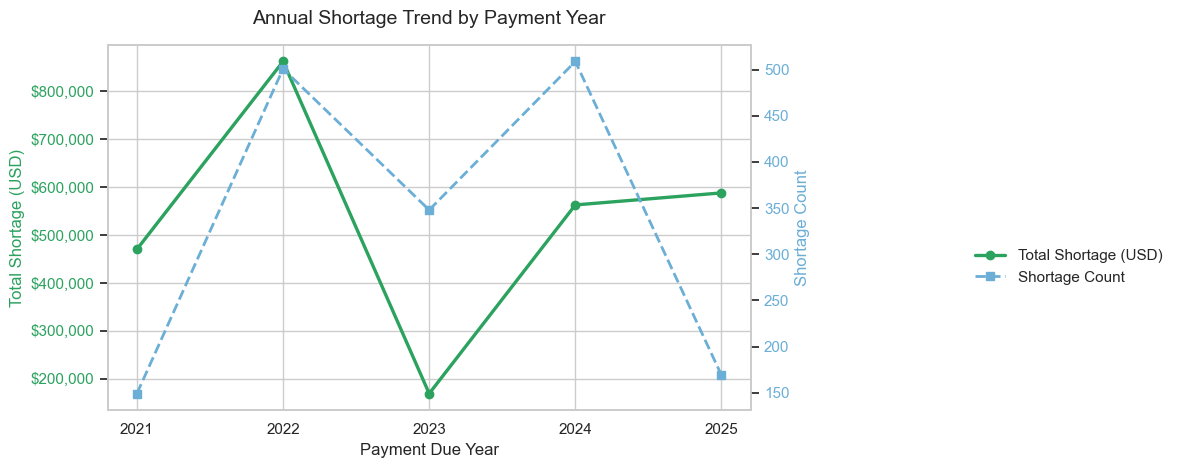

,Payment_Year,Shortage_Count,Total_Shortage_USD,Mean_Shortage_USD
0,2021,149,"$470,010","$3,154.43"
1,2022,501,"$862,129","$1,720.82"
2,2023,348,"$168,732",$484.86
3,2024,509,"$562,564","$1,105.23"
4,2025,169,"$587,655","$3,477.25"
5,Total,"1,676","$2,651,090",


In [36]:
# === Annual Shortage Trend + Styled Summary Table (High Contrast & Clean) ===
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

sns.set_theme(style="whitegrid")

# --- Ensure continuity across years ---
yrs = pd.Series(sorted(annual_shortages["Payment_Year"].dropna().unique()))
year_idx = pd.Index(range(int(yrs.min()), int(yrs.max()) + 1), name="Payment_Year")

annual_plot = (
    annual_shortages.set_index("Payment_Year")
    .reindex(year_idx, fill_value=0.0)
    .reset_index()
)

# --- Colors ---
COLOR_MONEY = "#2ca25f"      # green for financials
COLOR_COUNT = "#6baed6"      # sky-blue for count
HEADER_BG = "#334155"        # dark slate header background
HEADER_FG = "white"
TEXT_COLOR = "#111827"       # dark text for contrast
CELL_BG = "#f8fafc"          # very light background for readability
BORDER_COLOR = "#d1d5db"     # light neutral border

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(9.5, 5.5))

# Primary line — Total Shortage (USD)
ax.plot(
    annual_plot["Payment_Year"],
    annual_plot["Total_Shortage_USD"],
    color=COLOR_MONEY,
    marker="o",
    linewidth=2.4,
    label="Total Shortage (USD)"
)

# Currency formatting
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"${v:,.0f}"))
ax.set_xlabel("Payment Due Year")
ax.set_ylabel("Total Shortage (USD)", color=COLOR_MONEY)
ax.tick_params(axis="y", labelcolor=COLOR_MONEY)
ax.set_title("Annual Shortage Trend by Payment Year", fontsize=14, pad=15)

# Secondary line — Shortage Count
ax2 = ax.twinx()
ax2.plot(
    annual_plot["Payment_Year"],
    annual_plot["Shortage_Count"],
    color=COLOR_COUNT,
    marker="s",
    linestyle="--",
    linewidth=2,
    label="Shortage Count"
)
ax2.set_ylabel("Shortage Count", color=COLOR_COUNT)
ax2.tick_params(axis="y", labelcolor=COLOR_COUNT)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:,.0f}"))
ax2.grid(False)

# Legend outside to the right
lines, labels = [], []
for a in [ax, ax2]:
    line, label = a.get_legend_handles_labels()
    lines.extend(line)
    labels.extend(label)
fig.legend(lines, labels, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

# Final layout
ax.set_xticks(annual_plot["Payment_Year"])
plt.tight_layout(rect=[0, 0.12, 0.88, 1])  # space for table below & legend
plt.show()

# Table below — strong visual contrast with total row added
# Add total row for count and USD
annual_with_total = annual_plot.copy()
total_row = pd.DataFrame({
    "Payment_Year": ["Total"],
    "Shortage_Count": [annual_with_total["Shortage_Count"].sum()],
    "Total_Shortage_USD": [annual_with_total["Total_Shortage_USD"].sum()],
    "Mean_Shortage_USD": [np.nan]  # leave mean blank
})
annual_with_total = pd.concat([annual_with_total, total_row], ignore_index=True)

styled_table = (
    annual_with_total[["Payment_Year", "Shortage_Count", "Total_Shortage_USD", "Mean_Shortage_USD"]]
    .style.format({
        "Shortage_Count": "{:,.0f}",
        "Total_Shortage_USD": "${:,.0f}",
        "Mean_Shortage_USD": lambda x: "" if pd.isna(x) else f"${x:,.2f}"
    })
    .set_caption("Annual Shortage Summary by Payment Due Year (with Totals)")
    .set_table_styles(
        [
            # Caption
            {"selector": "caption", "props": [
                ("font-size", "13px"),
                ("font-weight", "bold"),
                ("text-align", "left"),
                ("padding", "8px 0 4px 0")
            ]},
            # Header styling (dark background, white text)
            {"selector": "th", "props": [
                ("text-align", "center"),
                ("background-color", HEADER_BG),
                ("color", HEADER_FG),
                ("font-weight", "bold"),
                ("border", f"1px solid {BORDER_COLOR}"),
                ("padding", "8px")
            ]},
            # Cell styling (light background, dark text)
            {"selector": "td", "props": [
                ("text-align", "center"),
                ("color", TEXT_COLOR),
                ("background-color", CELL_BG),
                ("padding", "6px 10px"),
                ("border", f"1px solid {BORDER_COLOR}")
            ]},
        ]
    )
    # Highlight total row
    .apply(lambda x: ["font-weight: bold; background-color: #e2e8f0;"
                      if x.name == len(annual_with_total) - 1 else "" for _ in x], axis=1)
)

display(styled_table)
